#### Importing libraries and setting up data

In [3]:
%reset -f

In [4]:
pip install pmdarima

  Using cached pmdarima-2.0.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl (2.1 MB)


In [5]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from seaborn import set_style
from datetime import datetime
from sklearn.model_selection import TimeSeriesSplit

from statsmodels.tsa.holtwinters import Holt
import statsmodels.api as sm
from statsmodels.tsa.api import ARIMA
from pmdarima import auto_arima

In [6]:
set_style("whitegrid")

In [7]:
appl = yf.Ticker("AAPL")
df = appl.history(period="max").reset_index().copy() #taking 10 years of stock data

In [8]:
df['Date'] = df['Date'].dt.strftime('%m/%d/%Y') #removing time from date and converting to string
df['Date'] = pd.to_datetime(df['Date'])  #converting back to date object
df = df[["Date","Close"]]
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month

In [9]:
df_train = df[(df['Date']>datetime(2012,1,1))&(df['Date']<=datetime(2022,12,31))]
df_test = df[(df['Date']>datetime(2023,1,1))&(df['Date']<=datetime(2023,12,31))]

#### Data Exploration

Text(0.5, 1.0, 'AAPL Price Data (2012-2023)')

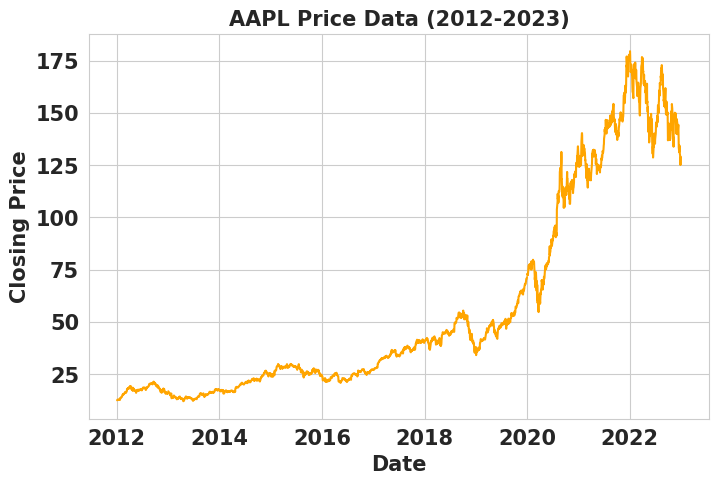

In [46]:
#@markdown Visualize dataset
plt.figure(figsize=(8,5))

for year in df['Year'].unique():
    yearly_data = df_train[df_train['Year']==year]
    plt.plot(yearly_data['Date'], yearly_data['Close'], color="orange")


plt.xlabel("Date",fontsize=15, fontweight="bold")
plt.ylabel("Closing Price", fontsize=15, fontweight="bold")
plt.xticks(fontsize=15, fontweight="bold")
plt.yticks(fontsize=15, fontweight="bold")
plt.title("AAPL Price Data (2012-2023)", fontsize=15, fontweight="bold")

# plt.xlabel('Date')
# plt.ylabel('Closing Price')
# plt.title('Closing Price vs Date for each Year')
#plt.legend()

(-1.1, 1.1)

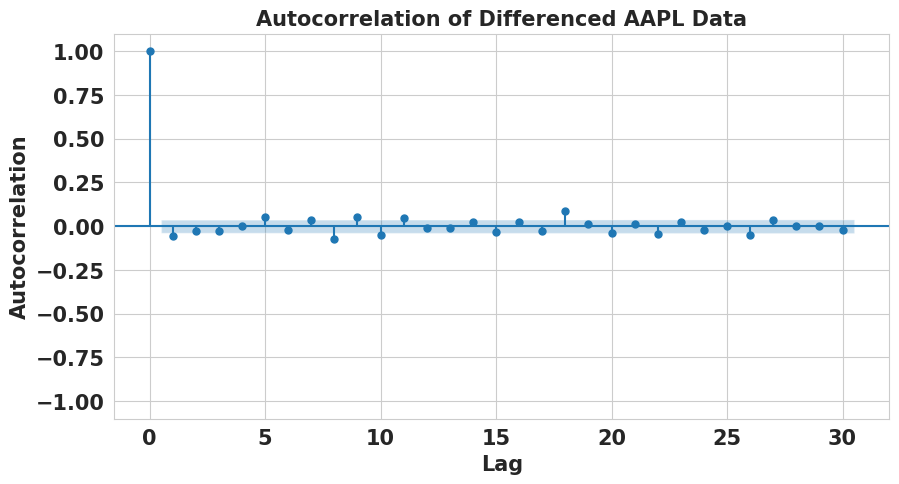

In [40]:
#@markdown Create acf plot after differencing the dataset once
fig, ax =  plt.subplots(1, 1, figsize=(10,5))

sm.graphics.tsa.plot_acf(df_train.Close.diff().values[1:],
                         lags = 30,
                         ax = ax)

plt.xlabel("Lag",fontsize=15, fontweight="bold")
plt.ylabel("Autocorrelation", fontsize=15, fontweight="bold")
plt.xticks(fontsize=15, fontweight="bold")
plt.yticks(fontsize=15, fontweight="bold")
plt.title("Autocorrelation of Differenced AAPL Data", fontsize=15, fontweight="bold")
plt.ylim(-1.1, 1.1)

#### Baseline - Linear Interpolation

In [12]:
# @title
# return the mean absolute error of the prediction on the test data
# relative to mean absolute error of the naive prediction on the training data
# If MASE > 1 then the prediction performs worse out of sample than naive forecast does in sample.
# If MASE < 1 then the prediction performs better out of sample than naive forecast does in sample.

# def mase(y_train_past, y_train, y_test, y_preds):
#     n = len(y_train_past)
#     m = len(y_test)
#     denom = 0
#     for i in range(n-m):
#         past_val = y_train[i]
#         future_val = y_train[i+m+1]
#         interpolation = np.linspace(past_val,future_val, m+2)[1:-1]
#         denom += np.abs(y_train[i+1:i+m+1] - interpolation).mean()
#         #print("past_value_0:",past_val, "interpolation_0:", interpolation,"true_value_0:",y_train[i+1:i+m+1], "future_value_0", future_val)
#     denom = denom / (n-m)
#     num = np.abs(y_test - y_preds).mean()
#     return num/denom

def calc_mase(y_train_past, y_train_future, y_test, y_preds):
    n = len(y_train_past)
    m = len(y_test)
    denom = 0

    past_val = y_train_past[-1]
    future_val = y_train_future[-1]

    lin_inter = np.linspace(past_val,future_val, m+2)[1:-1]
    err_lin_inter= np.mean((y_test - lin_inter) ** 2)

    err_pred = np.mean((y_test-y_preds)**2)
    return err_pred/err_lin_inter

#### Rolling average model

In [13]:
# @markdown Generate matrix of cross validation errors (errors are measured relative to linear interpolation)

start = 1
end = 20

test_sizes = np.arange(1,14,1)
weights = np.geomspace(0.125, 8, 21) #7
window_sizes = np.arange(start,end)

good_predictions_ra = set()
last_good_prediction_ra = -100

bad_predictions_ra = set()
last_bad_prediction_ra = -100


ra_mase = np.zeros((len(weights),len(test_sizes), 100, len(window_sizes)))

d = 0
for weight in weights:
  c=0
  for test_size in test_sizes:
    cv = TimeSeriesSplit(100, test_size=test_size)

    b=0
    for train_past_index, test_index in cv.split(df_train[:round(len(df_train)/2-1)]):
        max_index = len(df_train) - 1
        future_length = len(train_past_index)

        train_future_index = np.arange(test_index[-1] + 1, test_index[-1] + 1 + future_length)
        train_future_index = train_future_index[train_future_index <= max_index][::-1]

        past_tt = df_train.iloc[train_past_index]
        future_tt = df_train.iloc[train_future_index].reset_index().copy()
        hold_out = df_train.iloc[test_index]

        a = 0
        for window_size in window_sizes:
            pred = np.average([past_tt.Close.values[-window_size:].mean() * np.ones(len(hold_out)),
                            future_tt.Close.values[-window_size:].mean() * np.ones(len(hold_out))], axis=0, weights = [weight,1])

            ra_mase[d,c,b,a] = calc_mase(past_tt.Close.values, future_tt.Close.values, hold_out.Close.values, pred)

            if ra_mase[d,c,b,a] < 0.5 and test_size==5:
              last_good_prediction_ra = len(train_past_index)
              good_predictions_ra.add(tuple(df_train[len(train_past_index)-20:len(train_past_index)+25].Close.values))

            if ra_mase[d,c,b,a] > 2  and test_size==5:
              last_bad_prediction_ra = len(train_past_index)
              bad_predictions_ra.add(tuple(df_train[len(train_past_index)-20:len(train_past_index)+25].Close.values))
            a = a + 1
        b = b+1
    c=c+1
  d=d+1

ra_mase = np.mean(ra_mase, axis=(2))


Figures

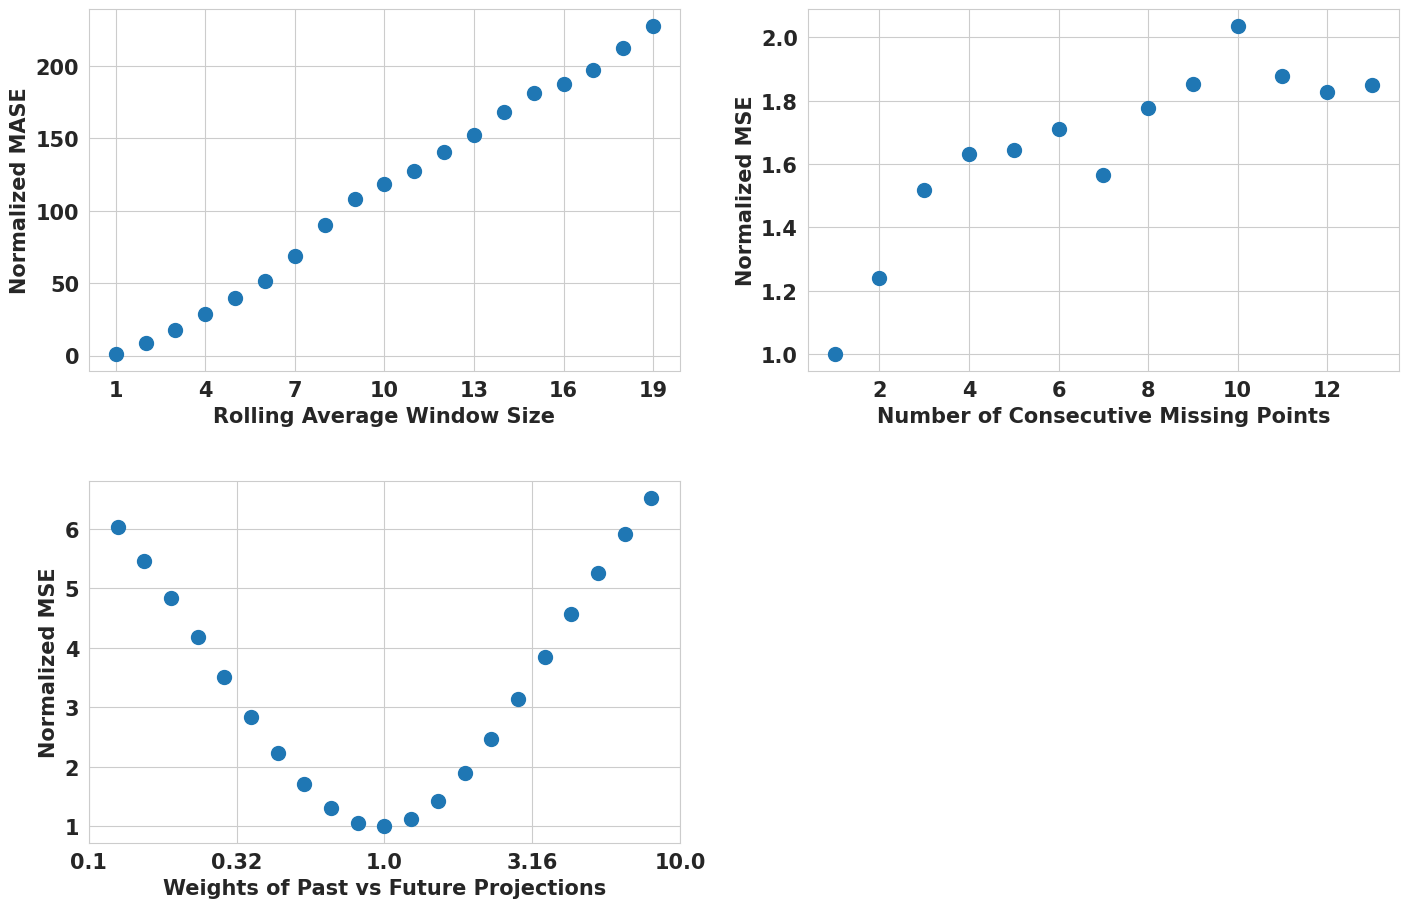



best weight = 1.0
best test size = 1
best window size = 1



In [19]:
# @markdown How mean absolute square error depends on parameters

index_for_min_mse_ra= np.where(ra_mase == np.min(ra_mase))

plt.figure(figsize=(15,10))

plt.subplot(2,2,1)

plt.scatter(window_sizes, ra_mase[index_for_min_mse_ra[0][0],index_for_min_mse_ra[1][0],:], s=100)

plt.xlabel("Rolling Average Window Size", fontsize=15, fontweight="bold")
plt.ylabel("Normalized MASE", fontsize=15, fontweight="bold")
plt.xticks(range(start, end, 3), fontsize=15, fontweight="bold")
plt.yticks(fontsize=15, fontweight="bold")
# plt.xlim(0, end)
# plt.ylim(0, np.max(ra_mase[index_for_min_mse_ra[0][0],index_for_min_mse_ra[1][0],:]))


plt.subplot(2,2,2)
plt.scatter(test_sizes, ra_mase[index_for_min_mse_ra[0][0],:,index_for_min_mse_ra[2][0]], s=100)

plt.xlabel("Number of Consecutive Missing Points", fontsize=15, fontweight="bold")
plt.ylabel("Normalized MSE", fontsize=15, fontweight="bold")
plt.xticks(fontsize=15, fontweight="bold")
plt.yticks(fontsize=15, fontweight="bold")


plt.subplot(2,2,3)
plt.scatter(weights, ra_mase[:,index_for_min_mse_ra[1][0],index_for_min_mse_ra[2][0]], s=100)

plt.xscale('log')
plt.xlabel("Weights of Past vs Future Projections", fontsize=15, fontweight="bold")
plt.ylabel("Normalized MSE", fontsize=15, fontweight="bold")
plt.xticks(np.logspace(-1, 1, 5), labels = [round(i,2) for i in np.logspace(-1, 1, 5)], fontsize=15, fontweight="bold")
plt.yticks(fontsize=15, fontweight="bold")

plt.tight_layout(pad=4)
plt.show()

print(f"""\n
best weight = {weights[index_for_min_mse_ra[0][0]]}
best test size = {test_sizes[index_for_min_mse_ra[1][0]]}
best window size = {window_sizes[index_for_min_mse_ra[2][0]]}
""")

#### A double exponential Smoothing Model

In [20]:
#@markdown Generate matrix of cross validation errors (errors are measured relative to linear interpolation)

test_sizes = np.arange(1,14,1)
weights = np.geomspace(0.125, 8, 21) #7
exp_mase = np.zeros((len(test_sizes), 100, len(weights)))

good_predictions_exp = set()
last_good_prediction_exp = -100

bad_predictions_exp = set()
last_bad_prediction_exp = -100


c=0
for test_size in test_sizes:
  exp_cv = TimeSeriesSplit(100, test_size=test_size)

  b=0
  for train_past_index, test_index in exp_cv.split(df_train[:round(len(df_train)/2-1)]):
    max_index = len(df_train) - 1
    future_length = len(train_past_index)

    train_future_index = np.arange(test_index[-1] + 1, test_index[-1] + 1 + future_length)
    train_future_index = train_future_index[train_future_index <= max_index][::-1]

    past_tt = df_train.iloc[train_past_index]
    future_tt = df_train.iloc[train_future_index].reset_index().copy()
    hold_out = df_train.iloc[test_index]

    exp_smooth_past = Holt(past_tt.Close.values).fit(optimized=True)
    exp_smooth_future = Holt(future_tt.Close.values).fit(optimized=True)

    impute_from_past = exp_smooth_past.forecast(len(hold_out))
    impute_from_future = exp_smooth_future.forecast(len(hold_out))[::-1]

    a =  0
    for weight in weights:
      pred = np.average([impute_from_past, impute_from_future], axis=0, weights = [weight,1])
      exp_mase[c,b,a] = calc_mase(past_tt.Close.values, future_tt.Close.values, hold_out.Close.values, pred)

      if exp_mase[c,b,a] < 0.8 and test_size==5:
        last_good_prediction_exp = len(train_past_index)
        good_predictions_exp.add(tuple(df_train[len(train_past_index)-20:len(train_past_index)+25].Close.values))

      if exp_mase[c,b,a] > 1.25 and test_size==5:
        last_bad_prediction_exp = len(train_past_index)
        bad_predictions_exp.add(tuple(df_train[len(train_past_index)-20:len(train_past_index)+25].Close.values))
      a = a + 1
    b = b+1
  c=c+1

exp_mase = np.mean(exp_mase, axis=(1))

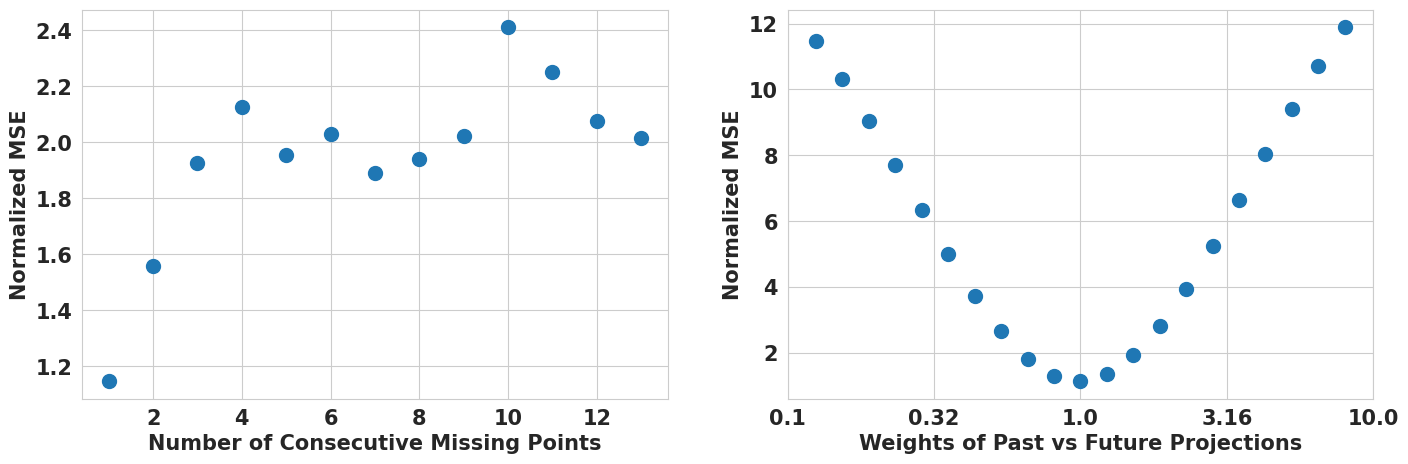



best weight = 1.0
best test size = 1



In [21]:
# @markdown Generate figures

index_for_min_mse_exp = np.where(exp_mase == np.min(exp_mase))

plt.figure(figsize=(15,10))

plt.subplot(2,2,1)

plt.scatter(test_sizes, exp_mase[:,index_for_min_mse_exp[1][0]], s=100)

plt.xlabel("Number of Consecutive Missing Points", fontsize=15, fontweight="bold")
plt.ylabel("Normalized MSE", fontsize=15, fontweight="bold")
plt.xticks(fontsize=15, fontweight="bold")
plt.yticks(fontsize=15, fontweight="bold")


plt.subplot(2,2,2)
plt.scatter(weights, exp_mase[index_for_min_mse_exp[0][0],:], s=100)

plt.xscale('log')
plt.xlabel("Weights of Past vs Future Projections", fontsize=15, fontweight="bold")
plt.ylabel("Normalized MSE", fontsize=15, fontweight="bold")
plt.xticks(np.logspace(-1, 1, 5), labels = [round(i,2) for i in np.logspace(-1, 1, 5)], fontsize=15, fontweight="bold")
plt.yticks(fontsize=15, fontweight="bold")

plt.tight_layout(pad=4)
plt.show()

print(f"""\n
best weight = {weights[index_for_min_mse_exp[1][0]]}
best test size = {test_sizes[index_for_min_mse_exp[0][0]]}
""")

#### ARIMA Model

In [27]:
#@markdown optimal parameters for ARIMA model

import warnings
warnings.filterwarnings('ignore')
#warnings.resetwarnings()

#, max_p=4, max_q=4

# auto_arima(df_train.Close.values, trace=False)

In [28]:
#@markdown Generate matrix of cross validation errors and print out mean absolute square errror and its standard deviation

test_sizes = np.arange(1,14,1)
weights = np.geomspace(0.125, 8, 21) #7
arima_mase = np.zeros((len(test_sizes), 100, len(weights)))


c=0
for test_size in test_sizes:
  arima_cv = TimeSeriesSplit(100, test_size=test_size)

  b = 0
  for train_past_index, test_index in arima_cv.split(df_train[:round(len(df_train)/2-1)]):
      max_index = len(df_train) - 1
      future_length = len(train_past_index)

      train_future_index = np.arange(test_index[-1] + 1, test_index[-1] + 1 + future_length)
      train_future_index = train_future_index[train_future_index <= max_index][::-1]

      past_tt = df_train.iloc[train_past_index]
      future_tt = df_train.iloc[train_future_index].reset_index().copy()
      hold_out = df_train.iloc[test_index]

      arima_past = ARIMA(past_tt.Close.values, order=(1,1,5)).fit() #(0,1,1)
      arima_future = ARIMA(future_tt.Close.values, order=(1,1,5)).fit()

      impute_from_past = arima_past.forecast(len(hold_out))
      impute_from_future = arima_future.forecast(len(hold_out)) [::-1]

      a =  0
      for weight in weights:
        pred = np.average([impute_from_past, impute_from_future], axis=0, weights = [weight,1])
        arima_mase[c,b,a] = calc_mase(past_tt.Close.values, future_tt.Close.values, hold_out.Close.values, pred)
        a = a + 1
      b = b+1
  c=c+1

arima_mase = np.mean(arima_mase, axis=(1))

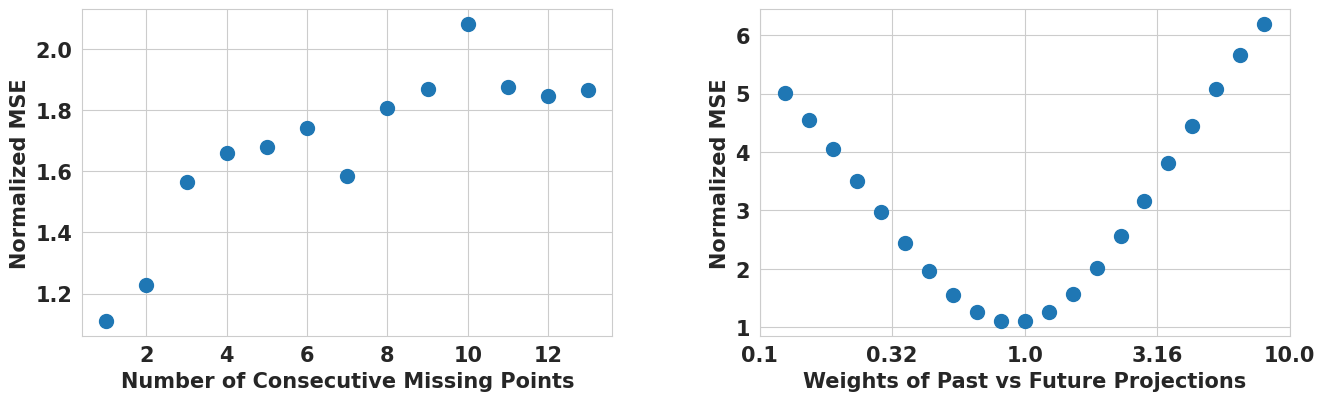



best weight = 1.0
best test size = 1



In [33]:
# @markdown Generate figures

index_for_min_mse_arima = np.where(arima_mase == np.min(arima_mase))

plt.figure(figsize=(15,10))

plt.subplot(2,2,1)

plt.scatter(test_sizes, arima_mase[:,index_for_min_mse_arima[1][0]], s=100)

plt.xlabel("Number of Consecutive Missing Points", fontsize=15, fontweight="bold")
plt.ylabel("Normalized MSE", fontsize=15, fontweight="bold")
plt.yticks(fontsize=15, fontweight="bold")
plt.xticks(fontsize=15, fontweight="bold")

plt.subplot(2,2,2)
plt.scatter(weights, arima_mase[index_for_min_mse_arima[0][0],:], s=100)

plt.xscale('log')
plt.xlabel("Weights of Past vs Future Projections", fontsize=15, fontweight="bold")
plt.ylabel("Normalized MSE", fontsize=15, fontweight="bold")
plt.xticks(np.logspace(-1, 1, 5), labels = [round(i,2) for i in np.logspace(-1, 1, 5)], fontsize=15, fontweight="bold")
plt.yticks(fontsize=15, fontweight="bold")

plt.tight_layout(pad=7)
plt.show()

print(f"""\n
best weight = {weights[index_for_min_mse_arima[1][0]]}
best test size = {test_sizes[index_for_min_mse_arima[0][0]]}
""")